Here I am mapping my crosses (pooled FASTQ) against the reference and doing a quick visual QC.

In [1]:
source("../../BrusselSprouts/scripts/functions.R")


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [20]:
jobname=""

In [2]:
fastq_dir="/home/jnrunge/data/trd/my_sequences/"

In [3]:
reference="/home/jnrunge/data/TRD/R64_nucl.fasta"

In [4]:
scripts_dir="/home/jnrunge/data/trd/mapped_reads/scripts/"

In [5]:
fastq_files=naturalsort(list.files(path=fastq_dir,pattern="txt.gz"))

In [6]:
print(fastq_files)

 [1] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_1_sequence.txt.gz"     
 [2] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_2_sequence.txt.gz"     
 [3] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_1_sequence.txt.gz"       
 [4] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_2_sequence.txt.gz"       
 [5] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_1_sequence.txt.gz"       
 [6] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_2_sequence.txt.gz"       
 [7] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC1_1_sequence.txt.gz"  
 [8] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC1_2_sequence.txt.gz"  
 [9] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC2_1_sequence.txt.gz"  
[10] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC2_2_sequence.txt.gz"  
[11] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC3A_1_sequence.txt.gz" 
[12] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC3A_

In [7]:
trimmed_files=list.files(path=paste0(fastq_dir, "trim_galore"),pattern="fq.gz$")
trimmed_files

[1] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_1_sequence.txt.gz_val_1.fq.gz"     
 [2] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_2_sequence.txt.gz_val_2.fq.gz"     
 [3] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_1_sequence.txt.gz_val_1.fq.gz"       
 [4] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_2_sequence.txt.gz_val_2.fq.gz"       
 [5] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_1_sequence.txt.gz_val_1.fq.gz"       
 [6] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_2_sequence.txt.gz_val_2.fq.gz"       
 [7] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC1_1_sequence.txt.gz_val_1.fq.gz"  
 [8] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC1_2_sequence.txt.gz_val_2.fq.gz"  
 [9] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC11_1_sequence.txt.gz_val_1.fq.gz" 
[10] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC11_2_sequence.txt.gz_val_2.fq.gz" 
[11] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC12_1_sequence.txt.gz_val_1.fq.gz" 
[12] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC12_2_sequence.txt.gz_val_2.fq.gz" 
[13] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC14_1_sequence.txt.gz_val_1.fq.gz" 
[14] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC14_2_sequence.txt.gz_val_2.fq.gz" 
[15] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC15_1_sequence.txt.gz_val_1.fq.gz" 
[16] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC15_2_sequence.txt.gz_val_2.fq.gz" 
[17] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC16_1_sequence.txt.gz_val_1.fq.gz" 
[18] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC16_2_sequence.txt.gz_val_2.fq.gz" 
[19] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC17_1_sequence.txt.gz_val_1.fq.gz" 
[20] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC17_2_sequence.txt.gz_val_2.fq.gz" 
[21] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC18_1_sequence.txt.gz_val_1.fq.gz" 
[22] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC18_2_sequence.txt.gz_val_2.fq.gz" 
[23] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC19_1_sequence.txt.gz_val_1.fq.gz" 
[24] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC19_2_sequence.txt.gz_val_2.fq.gz" 
[25] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC2_1_sequence.txt.gz_val_1.fq.gz"  
[26] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC2_2_sequence.txt.gz_val_2.fq.gz"  
[27] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC20A_1_sequence.txt.gz_val_1.fq.gz"
[28] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC20A_2_sequence.txt.gz_val_2.fq.gz"
[29] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC20B_1_sequence.txt.gz_val_1.fq.gz"
[30] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC20B_2_sequence.txt.gz_val_2.fq.gz"
[31] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC21A_1_sequence.txt.gz_val_1.fq.gz"
[32] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC21A_2_sequence.txt.gz_val_2.fq.gz"
[33] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC21B_1_sequence.txt.gz_val_1.fq.gz"
[34] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC21B_2_sequence.txt.gz_val_2.fq.gz"
[35] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC22_1_sequence.txt.gz_val_1.fq.gz" 
[36] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC22_2_sequence.txt.gz_val_2.fq.gz" 
[37] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC23A_1_sequence.txt.gz_val_1.fq.gz"
[38] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC23A_2_sequence.txt.gz_val_2.fq.gz"
[39] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC23B_1_sequence.txt.gz_val_1.fq.gz"
[40] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC23B_2_sequence.txt.gz_val_2.fq.gz"
[41] "AACK3HFM5_YJNRC_pool_23s001076-1-1_Schacherer_lane1YJNRC24_1_sequence.txt.gz_val_1.fq.gz" 
[42] "AACK3HFM5_YJNRC_po

In [9]:
# if >= 1 missing trimmed file

if(length(fastq_files)!=length(trimmed_files))
    {
    # write lines to ensure correct order
    writeLines(fastq_files, "~/data/trd/my_sequences/files.txt")
    cmd=paste0("cd ", fastq_dir, " && sh -xe ~/TRD/01_Mapping/01_Mapping-trimgalore.sh")
    execute_cmd_sbatch(cmd, mem="8gb", cpu="10", time="long", env="bwaetc", jobname="trim_galore")
    Sys.sleep(1)
}

In [10]:
# fastqc on trimmed files

for(f in trimmed_files){
    if(file.exists(paste0(fastq_dir,"trim_galore/fastqc/",
                         str_replace(f,fixed(".fq.gz"),"_fastqc.html")))){
        next
    }
    cmd=paste0("cd ",fastq_dir,"trim_galore && fastqc -o fastqc -t 1 -d . ",f,"")
    execute_cmd_sbatch(cmd, mem="4gb", cpu="1", time="short", env="bwaetc", jobname = "FastQC")
    Sys.sleep(1)
}

In [11]:
# need to find a smart way of getting sensible IDs

IDs=unlist(lapply(unlist(lapply(trimmed_files, getWhich, which=1, fixed=FALSE, split="[_][0-9][_][s]")), getWhich, which=2, split="lane1"))
IDs

[1] "JF3x1"    "JF3x1"    "JF4"      "JF4"      "JG4"      "JG4"     
 [7] "YJNRC1"   "YJNRC1"   "YJNRC11"  "YJNRC11"  "YJNRC12"  "YJNRC12" 
[13] "YJNRC14"  "YJNRC14"  "YJNRC15"  "YJNRC15"  "YJNRC16"  "YJNRC16" 
[19] "YJNRC17"  "YJNRC17"  "YJNRC18"  "YJNRC18"  "YJNRC19"  "YJNRC19" 
[25] "YJNRC2"   "YJNRC2"   "YJNRC20A" "YJNRC20A" "YJNRC20B" "YJNRC20B"
[31] "YJNRC21A" "YJNRC21A" "YJNRC21B" "YJNRC21B" "YJNRC22"  "YJNRC22" 
[37] "YJNRC23A" "YJNRC23A" "YJNRC23B" "YJNRC23B" "YJNRC24"  "YJNRC24" 
[43] "YJNRC25"  "YJNRC25"  "YJNRC26"  "YJNRC26"  "YJNRC27A" "YJNRC27A"
[49] "YJNRC27B" "YJNRC27B" "YJNRC29A" "YJNRC29A" "YJNRC29B" "YJNRC29B"
[55] "YJNRC30"  "YJNRC30"  "YJNRC31"  "YJNRC31"  "YJNRC32A" "YJNRC32A"
[61] "YJNRC32B" "YJNRC32B" "YJNRC34A" "YJNRC34A" "YJNRC34B" "YJNRC34B"
[67] "YJNRC3A"  "YJNRC3A"  "YJNRC3B"  "YJNRC3B"  "YJNRC4A"  "YJNRC4A" 
[73] "YJNRC4B"  "YJNRC4B"  "YJNRC5A"  "YJNRC5A"  "YJNRC5B"  "YJNRC5B" 
[79] "YJNRC6"   "YJNRC6"   "YJNRC7"   "YJNRC7"   "YJNRC8A"  "YJNRC8A" 
[85] "YJNRC8B"  "YJNRC8B"  "YJNRC9"   "YJNRC9"

In [12]:
df=data.frame(ID=IDs, file=trimmed_files)
if(nrow(df)%%2 != 0){
    stop("missing files!")
}

In [13]:
initial_timedate=Sys.time()

In [14]:
for(ID in unique(df$ID)){
    print(ID)
    
    if(file.exists(paste0("~/data/trd/mapped_reads/",ID,".m.sort.markdup.bam"))){
        next
    }
    
    
    cmd=paste0("cd ",fastq_dir,"trim_galore
bwa mem -t 5 -M -T 0 -a ",reference," ",df$file[df$ID==ID][1], " ",df$file[df$ID==ID][2], " > ~/data/trd/mapped_reads/",ID,".sam
samtools sort -n -m 800M -@ 5 -O BAM -o ~/data/trd/mapped_reads/",ID,".bam ~/data/trd/mapped_reads/",ID,".sam
rm -f ~/data/trd/mapped_reads/",ID,".sam
samtools fixmate -@ 5 -m ~/data/trd/mapped_reads/",ID,".bam ~/data/trd/mapped_reads/",ID,".m.bam
rm -f ~/data/trd/mapped_reads/",ID,".bam
samtools sort -m 800M -@ 5 -O bam -o ~/data/trd/mapped_reads/",ID,".m.sort.bam  ~/data/trd/mapped_reads/",ID,".m.bam 
rm -f ~/data/trd/mapped_reads/",ID,".m.bam
samtools stats ~/data/trd/mapped_reads/",ID,".m.sort.bam > ~/data/trd/mapped_reads/",ID,".m.sort.bam.stats
conda activate JupyteR4
Rscript ~/BrusselSprouts/scripts/getReadLengthsFromBamStats.R ~/data/trd/mapped_reads/",ID,".m.sort.bam.stats
conda activate bwaetc
rl=`cat ~/data/trd/mapped_reads/",ID,".m.sort.bam.stats-rl.txt`
echo Read Lengths detected as $rl
samtools markdup -l $rl -s -@ 5 ~/data/trd/mapped_reads/",ID,".m.sort.bam ~/data/trd/mapped_reads/",ID,".m.sort.markdup.bam
rm -f ~/data/trd/mapped_reads/",ID,".m.sort.bam 
samtools index ~/data/trd/mapped_reads/",ID,".m.sort.markdup.bam")
               
    sbatch_list=execute_complex_sbatch(cmd, jobname = "BWA", scripts_dir = scripts_dir, uniqueRunID = ID, cores="5", mem="5gb", time="short", env="bwaetc", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 20)

}

[1] "JF3x1"
[1] "JF4"
[1] "JG4"
[1] "YJNRC1"
[1] "YJNRC11"
[1] "YJNRC12"
[1] "YJNRC14"
[1] "YJNRC15"
[1] "YJNRC16"
[1] "YJNRC17"
[1] "YJNRC18"
[1] "YJNRC19"
[1] "YJNRC2"
[1] "YJNRC20A"
[1] "YJNRC20B"
[1] "YJNRC21A"
[1] "YJNRC21B"
[1] "YJNRC22"
[1] "YJNRC23A"
[1] "YJNRC23B"
[1] "YJNRC24"
[1] "YJNRC25"
[1] "YJNRC26"
[1] "YJNRC27A"
[1] "YJNRC27B"
[1] "YJNRC29A"
[1] "YJNRC29B"
[1] "YJNRC30"
[1] "YJNRC31"
[1] "YJNRC32A"
[1] "YJNRC32B"
[1] "YJNRC34A"
[1] "YJNRC34B"
[1] "YJNRC3A"
[1] "YJNRC3B"
[1] "YJNRC4A"
[1] "YJNRC4B"
[1] "YJNRC5A"
[1] "YJNRC5B"
[1] "YJNRC6"
[1] "YJNRC7"
[1] "YJNRC8A"
[1] "YJNRC8B"
[1] "YJNRC9"


In [15]:
if(exists("sbatch_list")){
    start_sbatch_list(sbatch_list, 2, "BWA", initial_timedate)
    }

In [16]:
bam_files=list.files(path="~/data/trd/mapped_reads",pattern="markdup.bam$",full.names = TRUE)
bam_files=bam_files[!grepl("tmp",bam_files,fixed = TRUE)]
length(bam_files)
bam_files

[1] 52

[1] "/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam" 
 [2] "/home/jnrunge/data/trd/mapped_reads/ChrisC2.m.sort.markdup.bam" 
 [3] "/home/jnrunge/data/trd/mapped_reads/ChrisC3.m.sort.markdup.bam" 
 [4] "/home/jnrunge/data/trd/mapped_reads/ChrisC4.m.sort.markdup.bam" 
 [5] "/home/jnrunge/data/trd/mapped_reads/ChrisC5.m.sort.markdup.bam" 
 [6] "/home/jnrunge/data/trd/mapped_reads/ChrisC6.m.sort.markdup.bam" 
 [7] "/home/jnrunge/data/trd/mapped_reads/ChrisC7.m.sort.markdup.bam" 
 [8] "/home/jnrunge/data/trd/mapped_reads/ChrisC8.m.sort.markdup.bam" 
 [9] "/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam"   
[10] "/home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam"     
[11] "/home/jnrunge/data/trd/mapped_reads/JG4.m.sort.markdup.bam"     
[12] "/home/jnrunge/data/trd/mapped_reads/YJNRC1.m.sort.markdup.bam"  
[13] "/home/jnrunge/data/trd/mapped_reads/YJNRC11.m.sort.markdup.bam" 
[14] "/home/jnrunge/data/trd/mapped_reads/YJNRC12.m.sort.markdup.bam" 
[15] "/home/jnrunge/data/trd/mapped_reads/YJNRC14.m.sort.markdup.bam" 
[16] "/home/jnrunge/data/trd/mapped_reads/YJNRC15.m.sort.markdup.bam" 
[17] "/home/jnrunge/data/trd/mapped_reads/YJNRC16.m.sort.markdup.bam" 
[18] "/home/jnrunge/data/trd/mapped_reads/YJNRC17.m.sort.markdup.bam" 
[19] "/home/jnrunge/data/trd/mapped_reads/YJNRC18.m.sort.markdup.bam" 
[20] "/home/jnrunge/data/trd/mapped_reads/YJNRC19.m.sort.markdup.bam" 
[21] "/home/jnrunge/data/trd/mapped_reads/YJNRC2.m.sort.markdup.bam"  
[22] "/home/jnrunge/data/trd/mapped_reads/YJNRC20A.m.sort.markdup.bam"
[23] "/home/jnrunge/data/trd/mapped_reads/YJNRC20B.m.sort.markdup.bam"
[24] "/home/jnrunge/data/trd/mapped_reads/YJNRC21A.m.sort.markdup.bam"
[25] "/home/jnrunge/data/trd/mapped_reads/YJNRC21B.m.sort.markdup.bam"
[26] "/home/jnrunge/data/trd/mapped_reads/YJNRC22.m.sort.markdup.bam" 
[27] "/home/jnrunge/data/trd/mapped_reads/YJNRC23A.m.sort.markdup.bam"
[28] "/home/jnrunge/data/trd/mapped_reads/YJNRC23B.m.sort.markdup.bam"
[29] "/home/jnrunge/data/trd/mapped_reads/YJNRC24.m.sort.markdup.bam" 
[30] "/home/jnrunge/data/trd/mapped_reads/YJNRC25.m.sort.markdup.bam" 
[31] "/home/jnrunge/data/trd/mapped_reads/YJNRC26.m.sort.markdup.bam" 
[32] "/home/jnrunge/data/trd/mapped_reads/YJNRC27A.m.sort.markdup.bam"
[33] "/home/jnrunge/data/trd/mapped_reads/YJNRC27B.m.sort.markdup.bam"
[34] "/home/jnrunge/data/trd/mapped_reads/YJNRC29A.m.sort.markdup.bam"
[35] "/home/jnrunge/data/trd/mapped_reads/YJNRC29B.m.sort.markdup.bam"
[36] "/home/jnrunge/data/trd/mapped_reads/YJNRC30.m.sort.markdup.bam" 
[37] "/home/jnrunge/data/trd/mapped_reads/YJNRC31.m.sort.markdup.bam" 
[38] "/home/jnrunge/data/trd/mapped_reads/YJNRC32A.m.sort.markdup.bam"
[39] "/home/jnrunge/data/trd/mapped_reads/YJNRC32B.m.sort.markdup.bam"
[40] "/home/jnrunge/data/trd/mapped_reads/YJNRC34A.m.sort.markdup.bam"
[41] "/home/jnrunge/data/trd/mapped_reads/YJNRC34B.m.sort.markdup.bam"
[42] "/home/jnrunge/data/trd/mapped_reads/YJNRC3A.m.sort.markdup.bam" 
[43] "/home/jnrunge/data/trd/mapped_reads/YJNRC3B.m.sort.markdup.bam" 
[44] "/home/jnrunge/data/trd/mapped_reads/YJNRC4A.m.sort.markdup.bam" 
[45] "/home/jnrunge/data/trd/mapped_reads/YJNRC4B.m.sort.markdup.bam" 
[46] "/home/jnrunge/data/trd/mapped_reads/YJNRC5A.m.sort.markdup.bam" 
[47] "/home/jnrunge/data/trd/mapped_reads/YJNRC5B.m.sort.markdup.bam" 
[48] "/home/jnrunge/data/trd/mapped_reads/YJNRC6.m.sort.markdup.bam"  
[49] "/home/jnrunge/data/trd/mapped_reads/YJNRC7.m.sort.markdup.bam"  
[50] "/home/jnrunge/data/trd/mapped_reads/YJNRC8A.m.sort.markdup.bam" 
[51] "/home/jnrunge/data/trd/mapped_reads/YJNRC8B.m.sort.markdup.bam" 
[52] "/home/jnrunge/data/trd/mapped_reads/YJNRC9.m.sort.markdup.bam"

In [21]:
for(b in bam_files){
    if(file.exists(paste0(b,".mq.tmp.tsv.gz","-windows.tsv.gz"))){
        next
    }
    jobname="MQ-QC"
    cmd=paste0("samtools view ",b," | cut -f 3,4,5 | gzip > ",b,".mq.tmp.tsv.gz")
    cmd=paste0(cmd,"
","conda activate JupyteR4 && Rscript ", "/home/jnrunge/TRD/01_Mapping/01_Mapping-MQ-windows.r ", b,".mq.tmp.tsv.gz")
    cmd=paste0(cmd,"
rm -f ",b,".mq.tmp.tsv.gz")
    print(cmd)
    
    sbatch_list=execute_complex_sbatch(cmd, jobname = jobname, scripts_dir = scripts_dir, uniqueRunID = basename(b), cores="1", mem="5gb", time="short", env="bwaetc", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 20)
}
if(exists("sbatch_list") &  jobname == "MQ-QC"){
    print(sbatch_list)
    start_sbatch_list(sbatch_list, 1, jobname, initial_timedate)
}

In [83]:
for(b in bam_files){
    if(file.exists(paste0(b,".depth.gz"))){
        next
    }
    jobname="SamDepths"
    cmd=paste0("sh -xe ~/TRD/01_Mapping/01_Mapping-depth.sh ",b)
    print(cmd)
    
    sbatch_list=execute_complex_sbatch(cmd, jobname = jobname, scripts_dir = scripts_dir, uniqueRunID = basename(b), cores="1", mem="4gb", time="long", env="bwaetc", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 30)
}
if(exists("sbatch_list") &  jobname == "SamDepths"){
    print(sbatch_list)
    start_sbatch_list(sbatch_list, 1, jobname, initial_timedate)
}

[1] "sh -xe ~/TRD/01_Mapping/01_Mapping-depth.sh /home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/SamDepths-ChrisC1.m.sort.markdup.bam.sbatch"
[1] "sh -xe ~/TRD/01_Mapping/01_Mapping-depth.sh /home/jnrunge/data/trd/mapped_reads/ChrisC2.m.sort.markdup.bam"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/SamDepths-ChrisC2.m.sort.markdup.bam.sbatch"
[1] "sh -xe ~/TRD/01_Mapping/01_Mapping-depth.sh /home/jnrunge/data/trd/mapped_reads/ChrisC3.m.sort.markdup.bam"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/SamDepths-ChrisC3.m.sort.markdup.bam.sbatch"
[1] "sh -xe ~/TRD/01_Mapping/01_Mapping-depth.sh /home/jnrunge/data/trd/mapped_reads/ChrisC4.m.sort.markdup.bam"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/SamDepths-ChrisC4.m.sort.markdup.bam.sbatch"
[1] "sh -xe ~/TRD/01_Mapping/01_Mapping-depth.sh /home/jnrunge/data/trd/mapped_reads/ChrisC5.m.sort.markdup.bam"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/SamDepths-

In [84]:
Depth_files=list.files(path="~/data/trd/mapped_reads",pattern="m.sort.markdup.bam.depth.gz$",full.names = TRUE)
Depth_df=tibble(file=Depth_files, meanCov=NA)
for(i in 1:nrow(Depth_df)){
    d=Depth_df$file[i]
    tmp<-fread(d, header = FALSE)
    Depth_df$meanCov[i]=mean(tmp$V3)
}

In [85]:
Depth_df$ID=unlist(lapply(basename(Depth_df$file), getFirst_v2, split="."))
head(Depth_df)

file,meanCov,ID
<chr>,<dbl>,<chr>
/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.depth.gz,65.96426,ChrisC1
/home/jnrunge/data/trd/mapped_reads/ChrisC2.m.sort.markdup.bam.depth.gz,90.69349,ChrisC2
/home/jnrunge/data/trd/mapped_reads/ChrisC3.m.sort.markdup.bam.depth.gz,80.47219,ChrisC3
/home/jnrunge/data/trd/mapped_reads/ChrisC4.m.sort.markdup.bam.depth.gz,72.96542,ChrisC4
/home/jnrunge/data/trd/mapped_reads/ChrisC5.m.sort.markdup.bam.depth.gz,62.37146,ChrisC5
/home/jnrunge/data/trd/mapped_reads/ChrisC6.m.sort.markdup.bam.depth.gz,95.17273,ChrisC6


In [86]:
Depth_df%>%arrange(meanCov)

file,meanCov,ID
<chr>,<dbl>,<chr>
/home/jnrunge/data/trd/mapped_reads/YJNRC17.m.sort.markdup.bam.depth.gz,11.03075,YJNRC17
/home/jnrunge/data/trd/mapped_reads/YJNRC18.m.sort.markdup.bam.depth.gz,12.77260,YJNRC18
/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.depth.gz,13.80244,JF3x1
/home/jnrunge/data/trd/mapped_reads/YJNRC34A.m.sort.markdup.bam.depth.gz,47.18299,YJNRC34A
/home/jnrunge/data/trd/mapped_reads/YJNRC32B.m.sort.markdup.bam.depth.gz,50.10105,YJNRC32B
/home/jnrunge/data/trd/mapped_reads/YJNRC8B.m.sort.markdup.bam.depth.gz,52.00402,YJNRC8B
/home/jnrunge/data/trd/mapped_reads/YJNRC29B.m.sort.markdup.bam.depth.gz,52.62432,YJNRC29B
/home/jnrunge/data/trd/mapped_reads/YJNRC32A.m.sort.markdup.bam.depth.gz,55.68406,YJNRC32A
/home/jnrunge/data/trd/mapped_reads/YJNRC34B.m.sort.markdup.bam.depth.gz,58.64435,YJNRC34B


In [87]:
Depth_df$ID

[1] "ChrisC1"  "ChrisC2"  "ChrisC3"  "ChrisC4"  "ChrisC5"  "ChrisC6" 
 [7] "ChrisC7"  "ChrisC8"  "JF3x1"    "JF4"      "JG4"      "YJNRC1"  
[13] "YJNRC11"  "YJNRC12"  "YJNRC14"  "YJNRC15"  "YJNRC16"  "YJNRC17" 
[19] "YJNRC18"  "YJNRC19"  "YJNRC2"   "YJNRC20A" "YJNRC20B" "YJNRC21A"
[25] "YJNRC21B" "YJNRC22"  "YJNRC23A" "YJNRC23B" "YJNRC24"  "YJNRC25" 
[31] "YJNRC26"  "YJNRC27A" "YJNRC27B" "YJNRC29A" "YJNRC29B" "YJNRC30" 
[37] "YJNRC31"  "YJNRC32A" "YJNRC32B" "YJNRC34A" "YJNRC34B" "YJNRC3A" 
[43] "YJNRC3B"  "YJNRC4A"  "YJNRC4B"  "YJNRC5A"  "YJNRC5B"  "YJNRC6"  
[49] "YJNRC7"   "YJNRC8A"  "YJNRC8B"  "YJNRC9"

In [88]:
Depth_df$filesize = file.info(str_replace(Depth_df$file,fixed(".depth.gz"),""))$size

In [89]:
Depth_df_bak=Depth_df

In [98]:
Depth_df=Depth_df_bak
for(ID in Depth_df$ID){
    if(endsWith(ID, "A")){
        ID_combined<- gsub("A$", "", ID)
        pattern <- paste0("^",ID_combined,"[A-B]")
        new_row <- tibble(file = NA, meanCov=Depth_df%>%filter(grepl(pattern, ID))%>%pull(meanCov)%>%sum(), ID = ID_combined,
                         filesize=Depth_df%>%filter(grepl(pattern, ID))%>%pull(filesize)%>%sum())
        Depth_df=filter(Depth_df, !grepl(pattern, ID))
        Depth_df <- bind_rows(Depth_df, new_row)
        next
    }
}

In [99]:
Depth_df%>%arrange(meanCov)

file,meanCov,ID,filesize
<chr>,<dbl>,<chr>,<dbl>
/home/jnrunge/data/trd/mapped_reads/YJNRC17.m.sort.markdup.bam.depth.gz,11.03075,YJNRC17,106818602
/home/jnrunge/data/trd/mapped_reads/YJNRC18.m.sort.markdup.bam.depth.gz,12.77260,YJNRC18,126852881
/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.depth.gz,13.80244,JF3x1,108954102
/home/jnrunge/data/trd/mapped_reads/ChrisC5.m.sort.markdup.bam.depth.gz,62.37146,ChrisC5,598598194
/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.depth.gz,65.96426,ChrisC1,755834109
/home/jnrunge/data/trd/mapped_reads/YJNRC15.m.sort.markdup.bam.depth.gz,67.75179,YJNRC15,634231825
/home/jnrunge/data/trd/mapped_reads/ChrisC7.m.sort.markdup.bam.depth.gz,68.07434,ChrisC7,576264781
/home/jnrunge/data/trd/mapped_reads/YJNRC7.m.sort.markdup.bam.depth.gz,70.61942,YJNRC7,710064325
/home/jnrunge/data/trd/mapped_reads/ChrisC4.m.sort.markdup.bam.depth.gz,72.96542,ChrisC4,668054553


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


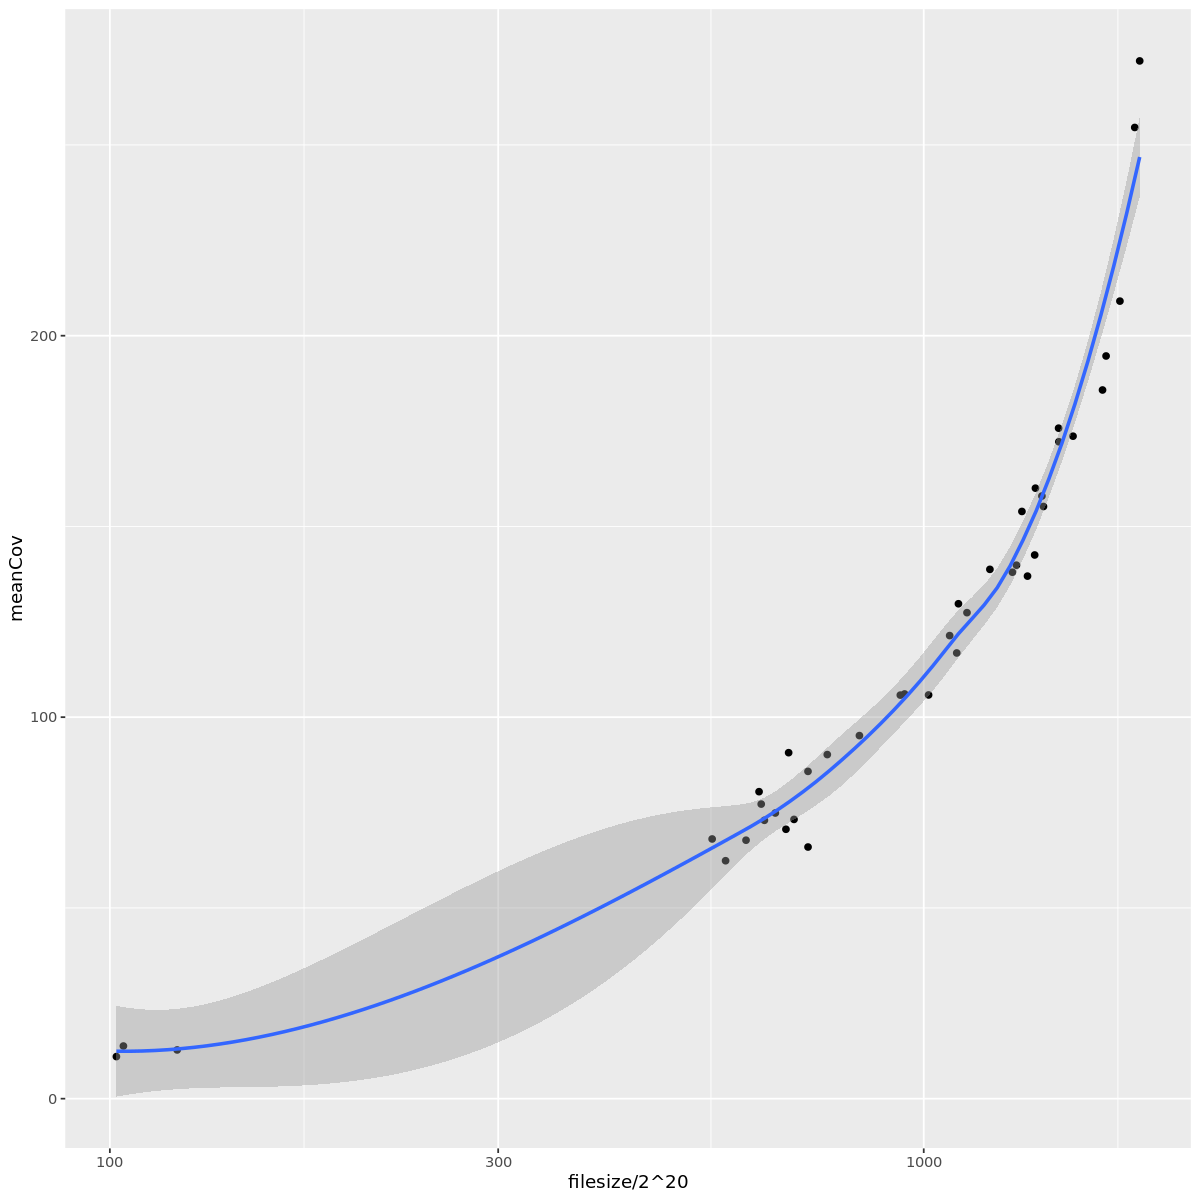

In [101]:
ggplot(Depth_df, aes(filesize/2^20, meanCov))+
geom_point()+scale_x_log10()+geom_smooth()

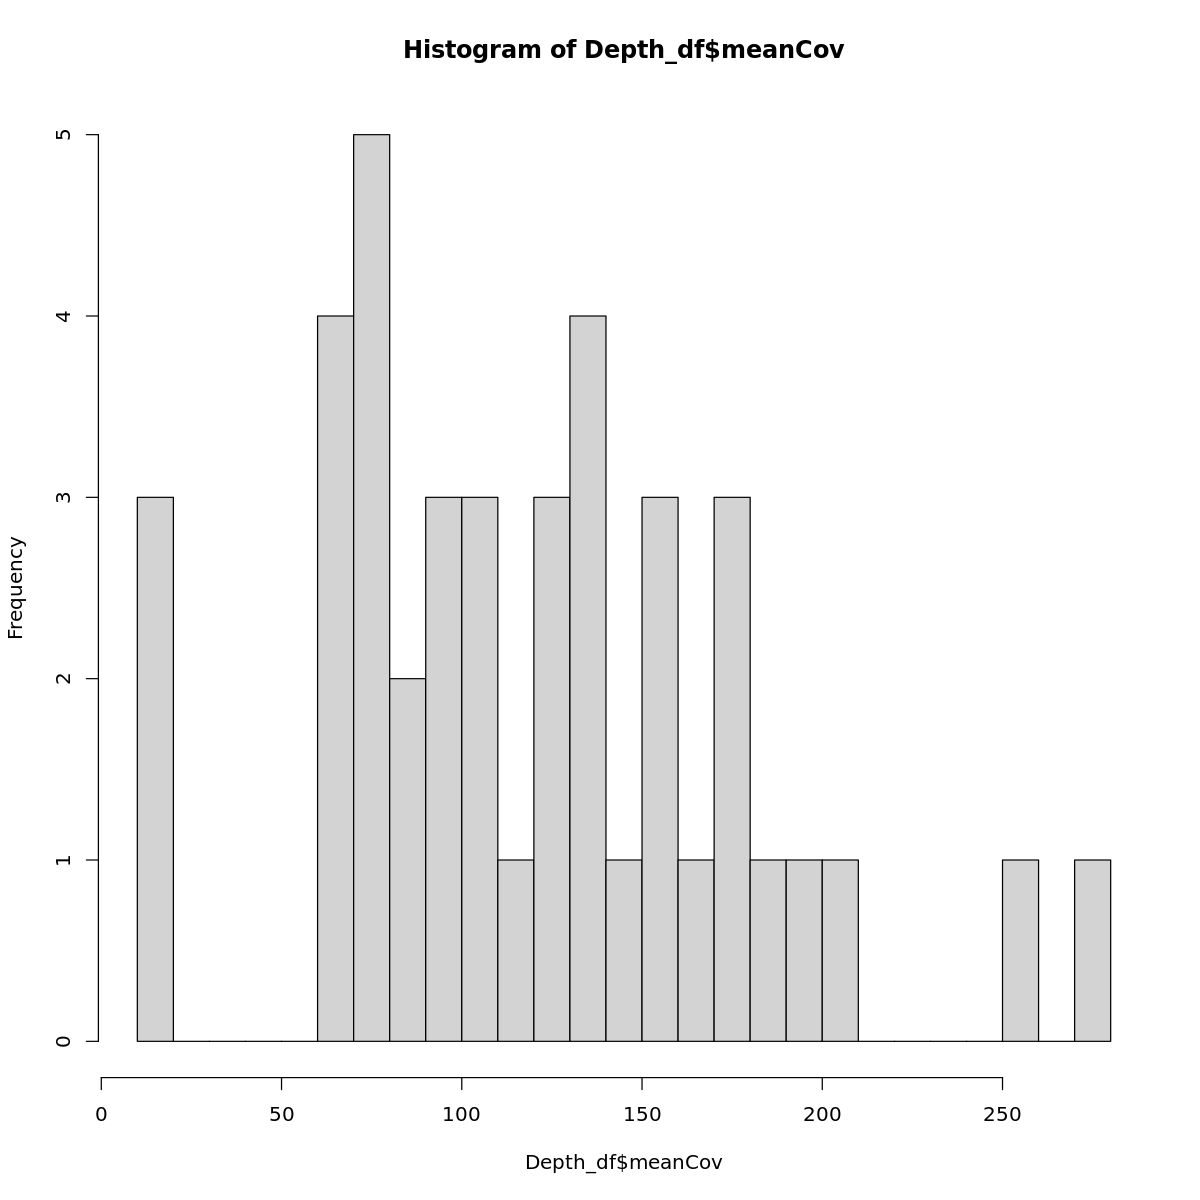

In [102]:
hist(Depth_df$meanCov, 30)

In [62]:
MQ_files=list.files(path="~/data/trd/mapped_reads",pattern="-windows.tsv.gz$",full.names = TRUE)
MQ_files

[1] "/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [2] "/home/jnrunge/data/trd/mapped_reads/ChrisC2.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [3] "/home/jnrunge/data/trd/mapped_reads/ChrisC3.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [4] "/home/jnrunge/data/trd/mapped_reads/ChrisC4.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [5] "/home/jnrunge/data/trd/mapped_reads/ChrisC5.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [6] "/home/jnrunge/data/trd/mapped_reads/ChrisC6.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [7] "/home/jnrunge/data/trd/mapped_reads/ChrisC7.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [8] "/home/jnrunge/data/trd/mapped_reads/ChrisC8.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
 [9] "/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"   
[10] "/home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"     
[11] "/home/jnrunge/data/trd/mapped_reads/JG4.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"     
[12] "/home/jnrunge/data/trd/mapped_reads/YJNRC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"  
[13] "/home/jnrunge/data/trd/mapped_reads/YJNRC11.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[14] "/home/jnrunge/data/trd/mapped_reads/YJNRC12.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[15] "/home/jnrunge/data/trd/mapped_reads/YJNRC14.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[16] "/home/jnrunge/data/trd/mapped_reads/YJNRC15.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[17] "/home/jnrunge/data/trd/mapped_reads/YJNRC16.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[18] "/home/jnrunge/data/trd/mapped_reads/YJNRC17.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[19] "/home/jnrunge/data/trd/mapped_reads/YJNRC18.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[20] "/home/jnrunge/data/trd/mapped_reads/YJNRC19.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[21] "/home/jnrunge/data/trd/mapped_reads/YJNRC2.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"  
[22] "/home/jnrunge/data/trd/mapped_reads/YJNRC20A.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[23] "/home/jnrunge/data/trd/mapped_reads/YJNRC20B.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[24] "/home/jnrunge/data/trd/mapped_reads/YJNRC21A.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[25] "/home/jnrunge/data/trd/mapped_reads/YJNRC21B.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[26] "/home/jnrunge/data/trd/mapped_reads/YJNRC22.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[27] "/home/jnrunge/data/trd/mapped_reads/YJNRC23A.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[28] "/home/jnrunge/data/trd/mapped_reads/YJNRC23B.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[29] "/home/jnrunge/data/trd/mapped_reads/YJNRC24.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[30] "/home/jnrunge/data/trd/mapped_reads/YJNRC25.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[31] "/home/jnrunge/data/trd/mapped_reads/YJNRC26.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[32] "/home/jnrunge/data/trd/mapped_reads/YJNRC27A.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[33] "/home/jnrunge/data/trd/mapped_reads/YJNRC27B.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[34] "/home/jnrunge/data/trd/mapped_reads/YJNRC29A.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[35] "/home/jnrunge/data/trd/mapped_reads/YJNRC29B.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[36] "/home/jnrunge/data/trd/mapped_reads/YJNRC30.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[37] "/home/jnrunge/data/trd/mapped_reads/YJNRC31.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz" 
[38] "/home/jnrunge/data/trd/mapped_reads/YJNRC32A.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[39] "/home/jnrunge/data/trd/mapped_reads/YJNRC32B.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[40] "/home/jnrunge/data/trd/mapped_reads/YJNRC34A.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[

In [63]:
MQ_df=fread_and_bind_files(MQ_files)
chrs=summarise(group_by(MQ_df, chr),maxPos=max(pos))
MQ_df$global_pos=MQ_df$pos
for(c in 2:length(unique(MQ_df$chr))){
    chr=unique(MQ_df$chr)[c]
    MQ_df$global_pos[MQ_df$chr==chr]=MQ_df$pos[MQ_df$chr==chr]+sum(chrs$maxPos[chrs$chr%in%unique(MQ_df$chr)[1:(c-1)]])
}
head(MQ_df)

,chr,pos,meanMQ,n,file,global_pos
,<chr>,<int>,<dbl>,<int>,<chr>,<int>
1,chromosome1,10001,52.03224,10950,/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,10001
2,chromosome1,20001,50.94978,2449,/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,20001
3,chromosome1,30001,51.86585,4644,/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,30001
4,chromosome1,40001,56.34332,20136,/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,40001
5,chromosome1,50001,59.28026,14576,/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,50001
6,chromosome1,60001,59.34670,12714,/home/jnrunge/data/trd/mapped_reads/ChrisC1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,60001


In [64]:
MQ_df$ID=unlist(lapply(basename(MQ_df$file), getFirst_v2, split="."))

Warning message:
"Removed 781 rows containing missing values (`geom_point()`)."


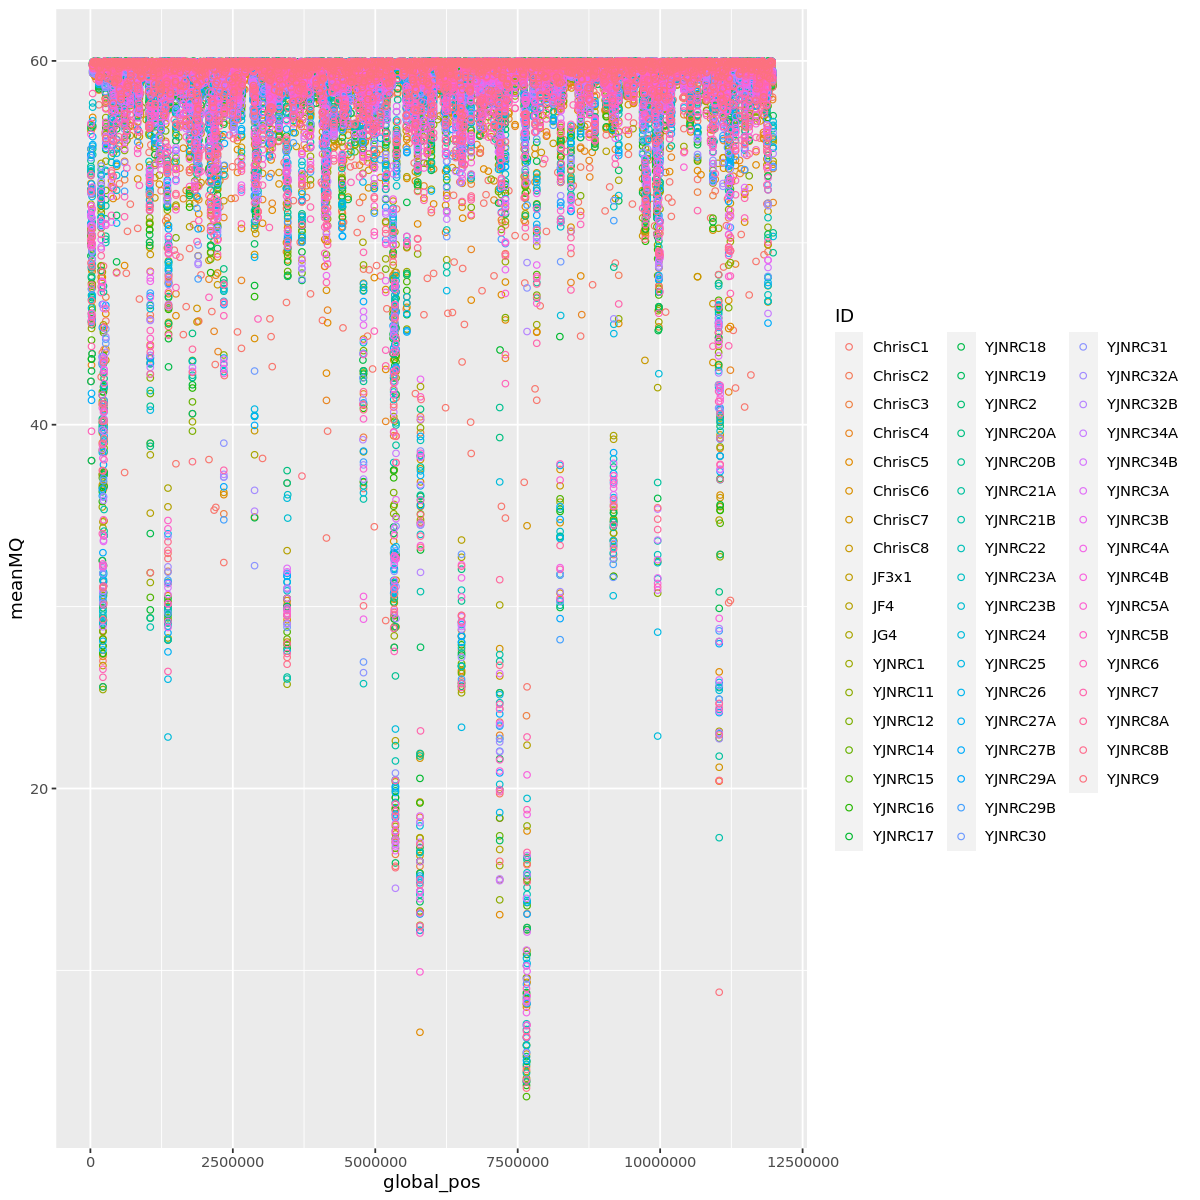

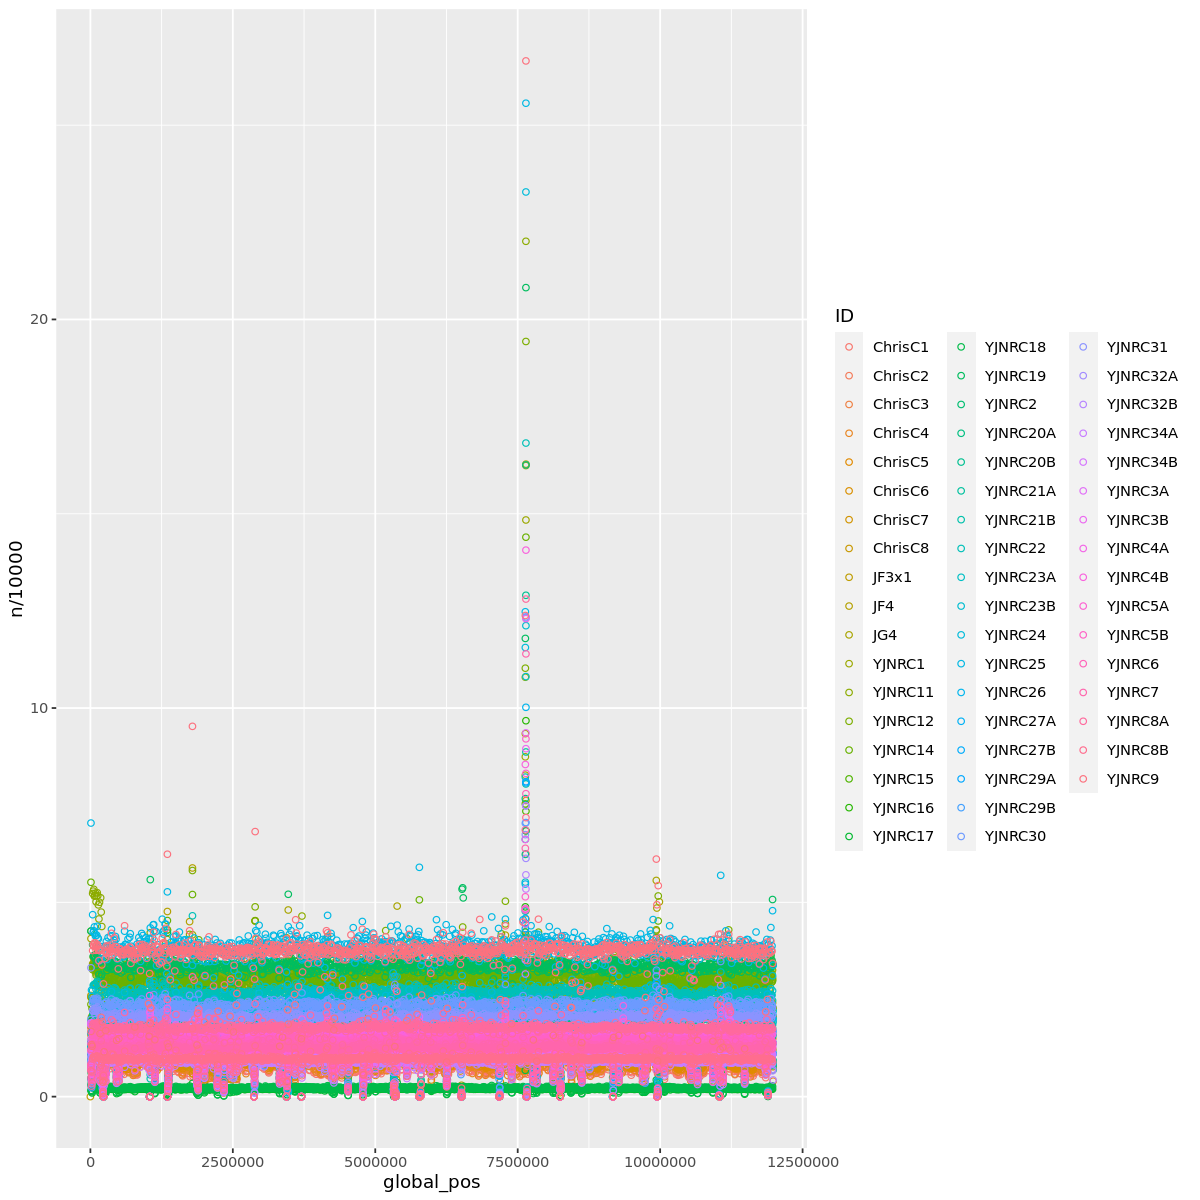

In [65]:
library(ggplot2)
ggplot(MQ_df, aes(global_pos, meanMQ, color=ID))+
geom_point(shape=1)
ggplot(MQ_df, aes(global_pos, n/10000, color=ID))+
geom_point(shape=1)

In [66]:
basename(bam_files)

[1] "ChrisC1.m.sort.markdup.bam"  "ChrisC2.m.sort.markdup.bam" 
 [3] "ChrisC3.m.sort.markdup.bam"  "ChrisC4.m.sort.markdup.bam" 
 [5] "ChrisC5.m.sort.markdup.bam"  "ChrisC6.m.sort.markdup.bam" 
 [7] "ChrisC7.m.sort.markdup.bam"  "ChrisC8.m.sort.markdup.bam" 
 [9] "JF3x1.m.sort.markdup.bam"    "JF4.m.sort.markdup.bam"     
[11] "JG4.m.sort.markdup.bam"      "YJNRC1.m.sort.markdup.bam"  
[13] "YJNRC11.m.sort.markdup.bam"  "YJNRC12.m.sort.markdup.bam" 
[15] "YJNRC14.m.sort.markdup.bam"  "YJNRC15.m.sort.markdup.bam" 
[17] "YJNRC16.m.sort.markdup.bam"  "YJNRC17.m.sort.markdup.bam" 
[19] "YJNRC18.m.sort.markdup.bam"  "YJNRC19.m.sort.markdup.bam" 
[21] "YJNRC2.m.sort.markdup.bam"   "YJNRC20A.m.sort.markdup.bam"
[23] "YJNRC20B.m.sort.markdup.bam" "YJNRC21A.m.sort.markdup.bam"
[25] "YJNRC21B.m.sort.markdup.bam" "YJNRC22.m.sort.markdup.bam" 
[27] "YJNRC23A.m.sort.markdup.bam" "YJNRC23B.m.sort.markdup.bam"
[29] "YJNRC24.m.sort.markdup.bam"  "YJNRC25.m.sort.markdup.bam" 
[31] "YJNRC26.m.sort.markdup.bam"  "YJNRC27A.m.sort.markdup.bam"
[33] "YJNRC27B.m.sort.markdup.bam" "YJNRC29A.m.sort.markdup.bam"
[35] "YJNRC29B.m.sort.markdup.bam" "YJNRC30.m.sort.markdup.bam" 
[37] "YJNRC31.m.sort.markdup.bam"  "YJNRC32A.m.sort.markdup.bam"
[39] "YJNRC32B.m.sort.markdup.bam" "YJNRC34A.m.sort.markdup.bam"
[41] "YJNRC34B.m.sort.markdup.bam" "YJNRC3A.m.sort.markdup.bam" 
[43] "YJNRC3B.m.sort.markdup.bam"  "YJNRC4A.m.sort.markdup.bam" 
[45] "YJNRC4B.m.sort.markdup.bam"  "YJNRC5A.m.sort.markdup.bam" 
[47] "YJNRC5B.m.sort.markdup.bam"  "YJNRC6.m.sort.markdup.bam"  
[49] "YJNRC7.m.sort.markdup.bam"   "YJNRC8A.m.sort.markdup.bam" 
[51] "YJNRC8B.m.sort.markdup.bam"  "YJNRC9.m.sort.markdup.bam"

fastq,bam,Jname
<lgl>,<chr>,<chr>
NA,JF3x1.m.sort.markdup.bam,YJNRC2.bam
NA,JF4.m.sort.markdup.bam,YJNRC17.bam
NA,JG4.m.sort.markdup.bam,YJNRC18.bam


[1] "ln -sf JF3x1.m.sort.markdup.bam YJNRC2.bam"
character(0)
[1] "ln -sf JF3x1.m.sort.markdup.bam.bai YJNRC2.bam.bai"
character(0)
[1] "ln -sf JF4.m.sort.markdup.bam YJNRC17.bam"
character(0)
[1] "ln -sf JF4.m.sort.markdup.bam.bai YJNRC17.bam.bai"
character(0)
[1] "ln -sf JG4.m.sort.markdup.bam YJNRC18.bam"
character(0)
[1] "ln -sf JG4.m.sort.markdup.bam.bai YJNRC18.bam.bai"
character(0)
